# Feature Points Detection

## Load Dataset

In [122]:
import cv2
import datetime
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import random
import os

%matplotlib inline

In [123]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_COLOR)
        if img is not None:
            images.append(img)
    return images

In [124]:
images_path = '../data/datasets/television_dataset/images'
images = load_images_from_folder(images_path)
sample_size = 4
sequential = True
plot_dpi = 144

images_count = len(images)
if sequential:
    start = random.randint(0, images_count - sample_size)
    taken_images_index = [*range(start, start + sample_size)]
else:
    taken_images_index = random.sample(range(images_count), sample_size if images_count > sample_size else images_count)
print('Taken {} from {} images'.format(taken_images_index, images_count))

sample_images = [images[i] for i in taken_images_index]
gray_images = []

for i in taken_images_index:
    gray_image = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
    gray_images.append(gray_image)

gray_image_index_pairs = [e for e in it.permutations(np.arange(len(gray_images)), 2)]
print('Gray image pairs: {}'.format(gray_image_index_pairs))

Taken [30, 31, 32, 33] from 40 images
Gray image pairs: [(0, 1), (0, 2), (0, 3), (1, 0), (1, 2), (1, 3), (2, 0), (2, 1), (2, 3), (3, 0), (3, 1), (3, 2)]


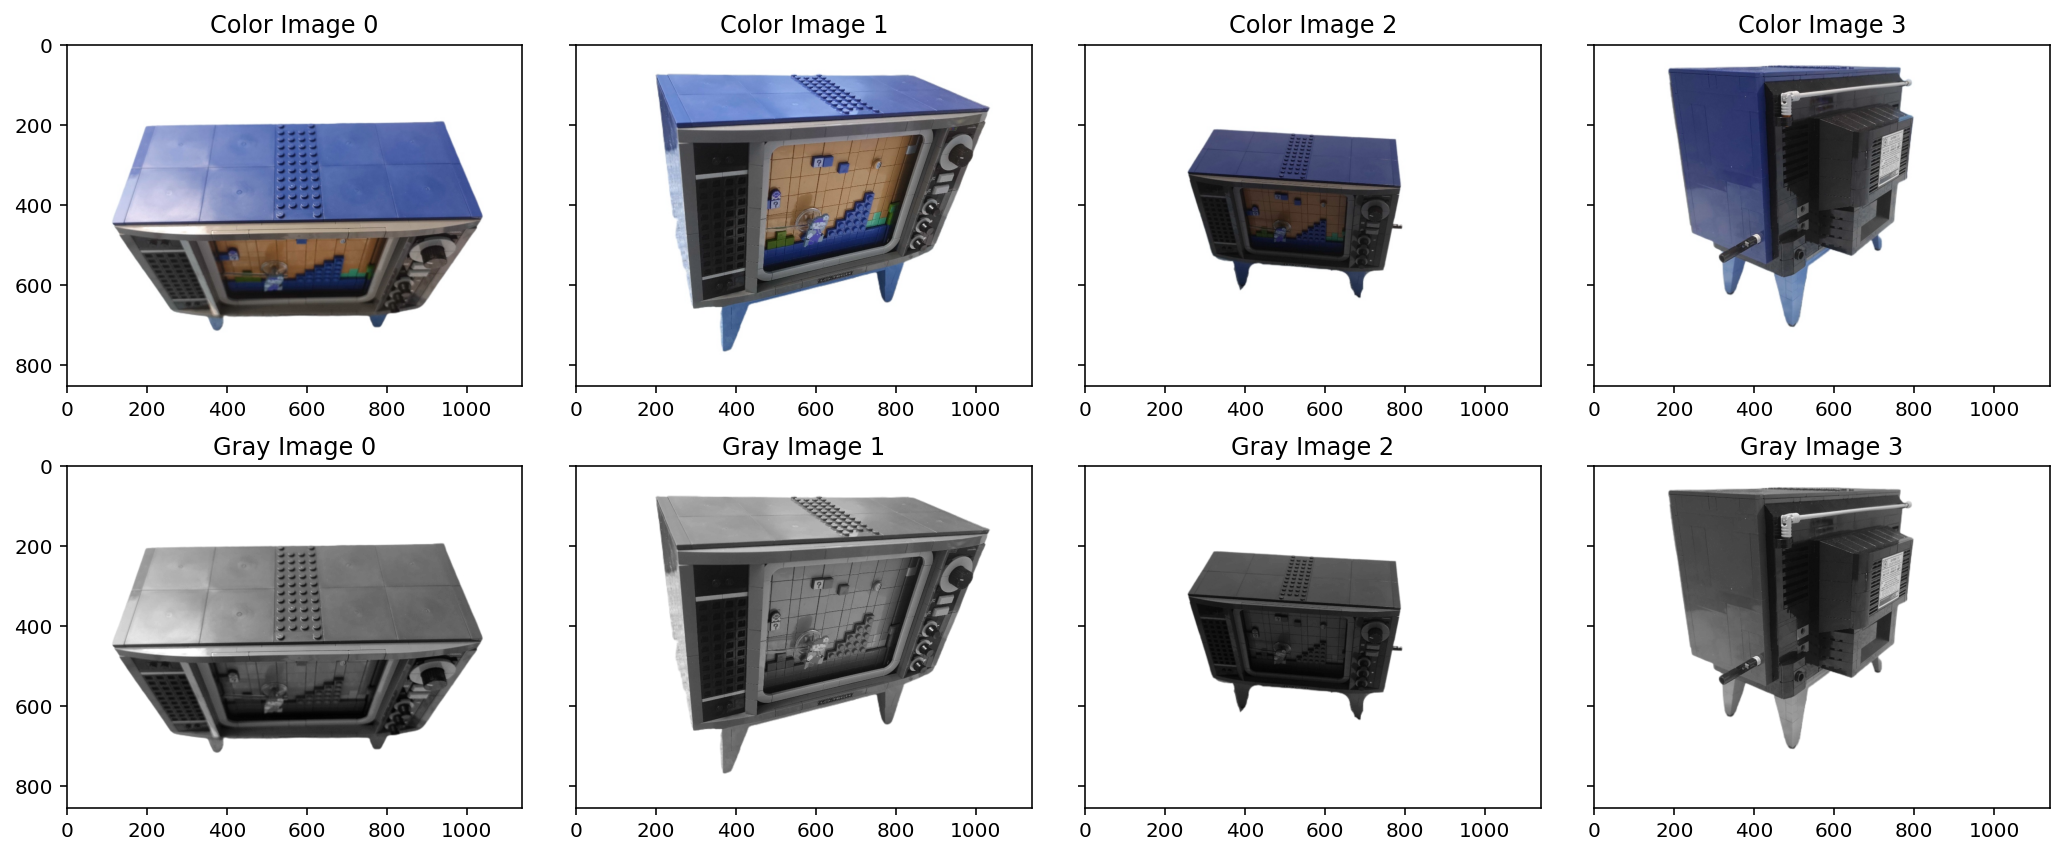

In [125]:
def display_samples(images):
    fig, ax = plt.subplots(2, len(images), figsize=(14.5, 6), constrained_layout=True, sharey=True)
    fig.set_dpi(plot_dpi)
    fig.tight_layout()

    for i in range(len(images)):
        ax[0, i].set_title('Color Image {}'.format(i))
        ax[0, i].imshow(images[i])
        ax[1, i].set_title('Gray Image {}'.format(i))
        ax[1, i].imshow(gray_images[i], cmap='gray')

display_samples(sample_images)

## Feature Matching


### SIFT Algorithm

#### Detect Feature Points

In [127]:
sift = cv2.SIFT_create()

feature_points = []
descriptors = []
sift_time_ms = []

for gray_image in gray_images:
    b = datetime.datetime.now()
    kps, des = sift.detectAndCompute(gray_image, None)
    e = datetime.datetime.now()
    
    sift_time_ms.append((e - b).microseconds / 1000)
    feature_points.append(kps)
    descriptors.append(des)

sift_time_ms

[100.948, 80.842, 74.946, 76.761]

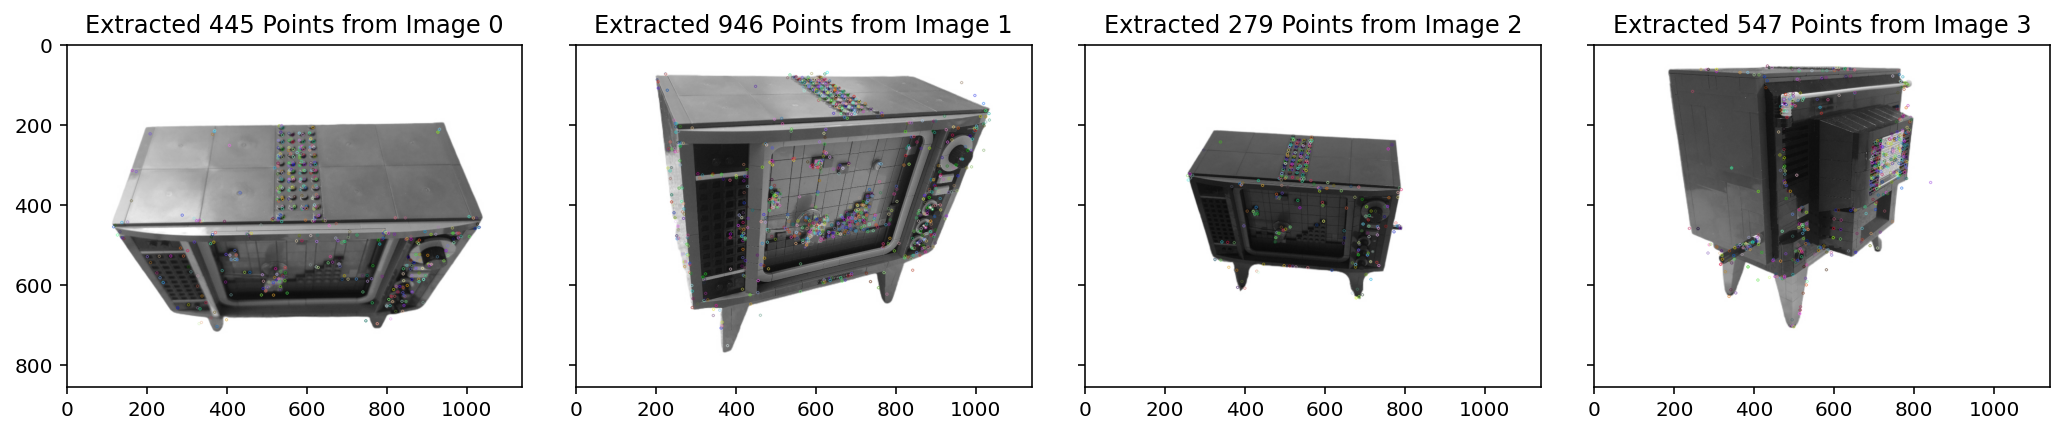

In [128]:
def display_feature_points(images, points):
    fig, ax = plt.subplots(1, len(images), figsize=(14.5, 6), constrained_layout=True, sharey=True)
    fig.set_dpi(plot_dpi)
    fig.tight_layout()

    for i in range(len(images)):
        ax[i].set_title('Extracted {} Points from Image {}'.format(len(feature_points[i]), i))
        image_with_points = cv2.drawKeypoints(images[i], points[i], None)
        ax[i].imshow(image_with_points)

display_feature_points(gray_images, feature_points)

#### Matching Feature Points using FLANN

In [129]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann_matcher = cv2.FlannBasedMatcher(index_params, search_params)
flann_matches =[]
flann_good_matches = []
flann_time_ms = []

# ratio test as per Lowe's paper
ratio_thresh = 0.8

for (i, j) in gray_image_index_pairs:
    good_matches = []

    b = datetime.datetime.now()
    matches = flann_matcher.knnMatch(descriptors[i], descriptors[j], k=2)
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    e = datetime.datetime.now()
    
    flann_time_ms.append((e - b).microseconds / 1000)
    flann_matches.append(matches)
    flann_good_matches.append(good_matches)

flann_time_ms

[18.081,
 5.478,
 9.371,
 14.784,
 9.864,
 15.744,
 3.846,
 7.432,
 4.492,
 7.816,
 14.894,
 4.846]

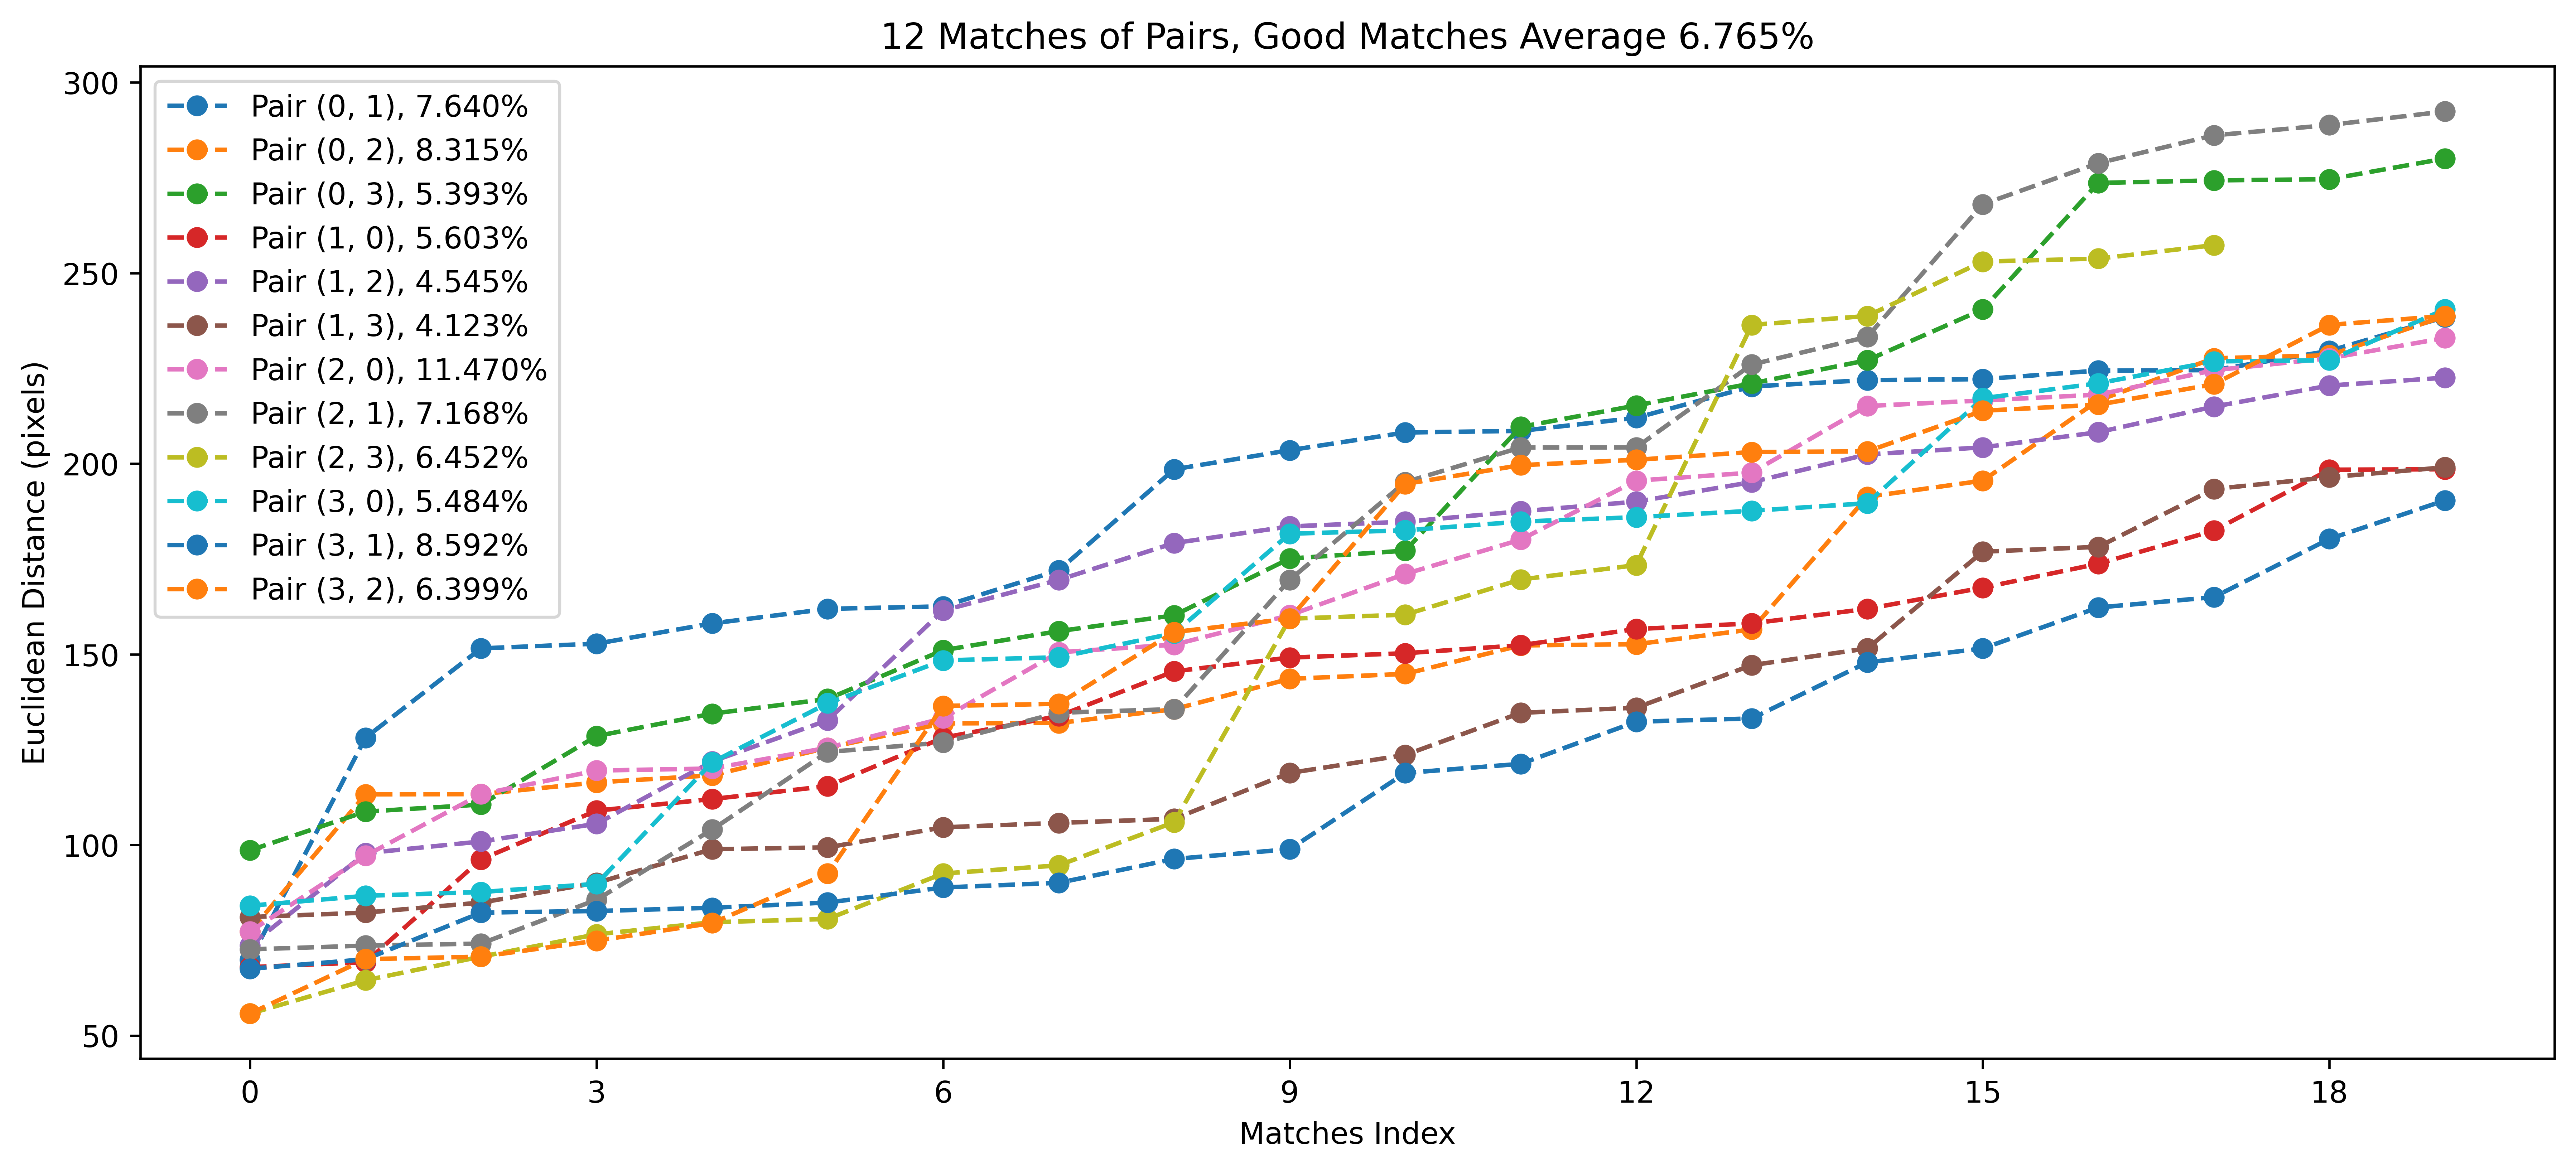

In [165]:
def display_matches_quality(index_pairs, good_matches, all_matches, n=20):
    good_matches_sorted = [sorted(gm, key=lambda val: val.distance) for gm in good_matches]
    distances = [[m.distance for m in gm_sorted] for gm_sorted in good_matches_sorted]
    percentages = [(len(gm_sorted) / len(am)) for (gm_sorted, am) in zip(good_matches_sorted, all_matches)]
    
    plt.figure(figsize=(14.5, 6), dpi=600)
    plt.title('{} Matches of Pairs, Good Matches Average {:.3f}%'.format(len(good_matches), np.average(percentages) * 100))
    plt.xticks(range(0, n, 3))
    plt.xlabel('Matches Index')
    plt.ylabel('Euclidean Distance (pixels)')

    for (ip, y, p) in zip(index_pairs, distances, percentages):
        x = np.arange(0, len(y))
        plt.plot(x[:n], y[:n], linestyle='--', marker='o', label='Pair {}, {:.3f}%'.format(ip, p * 100))
        plt.legend()

display_matches_quality(gray_image_index_pairs, flann_good_matches, flann_matches)


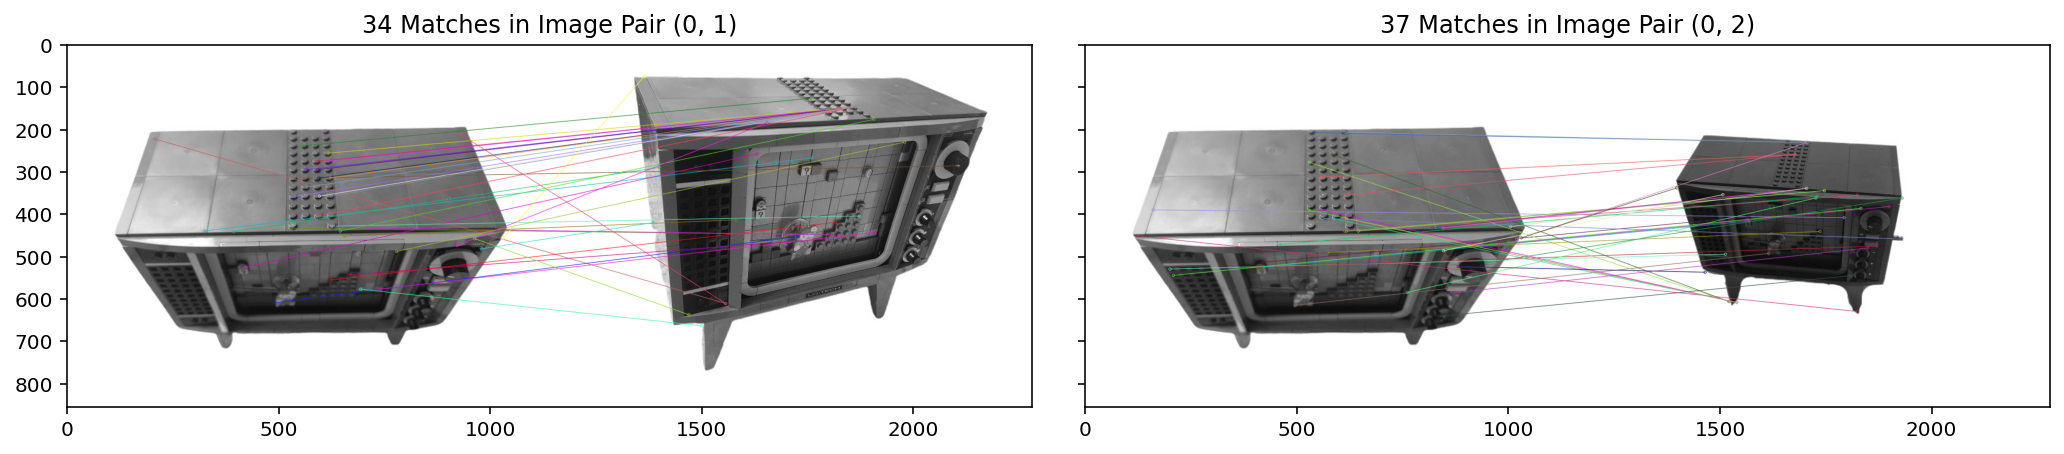

In [131]:
def display_matches(index_pairs, gray_images, feature_points, good_matches, n=2):
    fig, ax = plt.subplots(1, n, figsize=(14.5, 6), constrained_layout=True, sharey=True)
    fig.set_dpi(plot_dpi)
    fig.tight_layout()

    for ((i, j), k) in zip(index_pairs[:n], range(0, n)):
        stitch_image = np.empty(
            (max(gray_images[i].shape[0], gray_images[j].shape[0]), gray_images[i].shape[1] + gray_images[j].shape[1], 3),
            dtype=np.uint8
        )

        cv2.drawMatches(
            gray_images[i], feature_points[i],
            gray_images[j], feature_points[j],
            good_matches[k], stitch_image,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )

        ax[k].set_title('{} Matches in Image Pair {}'.format(len(good_matches[k]), (i, j)))
        ax[k].imshow(stitch_image)

display_matches(gray_image_index_pairs, gray_images, feature_points, flann_good_matches)


### SuperPoint + SuperGlue

#### Detect Feature Points using SuperPoint

In [134]:
import matplotlib.cm as cm
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running inference on device \"{}\"'.format(device))

Running inference on device "cpu"


In [135]:
from thirdparty.SuperPointPretrainedNetwork.superpoint import SuperPoint

superpoint_conf = {
    'descriptor_dim': 256,
    'nms_radius': 3,
    'max_keypoints': 4096,
    'keypoints_threshold': 0.6
}

sp_model = SuperPoint(superpoint_conf)
sp_model.eval()

SuperPoint(
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPb): Conv2d(256, 65, kernel_size=(1, 1), stride=(1, 1))
  (convDa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convDb): Conv2d(25

In [136]:
pretrained_sp_model = torch.load(
    'thirdparty/SuperPointPretrainedNetwork/superpoint_v1.pth',
    map_location=device
)
sp_model.load_state_dict(pretrained_sp_model, strict=True)

<All keys matched successfully>

In [141]:
def normalize_to_tensor(image):
    normalized = image.astype('float32') / 255.
    tensor = torch.from_numpy(normalized).to(device).unsqueeze(0).unsqueeze(0)
    return tensor

normalized_gray_images = [normalize_to_tensor(img) for img in gray_images]

print(gray_images[0].shape)
print(normalized_gray_images[0].shape)

(855, 1140)
torch.Size([1, 1, 855, 1140])


In [144]:
sp_predicts = []
sp_time_ms =[]

for t in normalized_gray_images:
    b = datetime.datetime.now()
    pred = sp_model(t)
    e = datetime.datetime.now()

    sp_time_ms.append((e - b).microseconds / 1000)
    sp_predicts.append(pred)

print(sp_predicts[0].keys())
print(sp_time_ms)

/Users/unbinilium/Documents/Develop/Python/SfM/lib/python3.10/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


dict_keys(['keypoints', 'scores', 'descriptors'])
[879.075, 656.856, 552.916, 540.574]


In [145]:
keypoints = [p['keypoints'][0].detach().numpy() for p in sp_predicts]
scores = [p['scores'][0].detach().numpy() for p in sp_predicts]

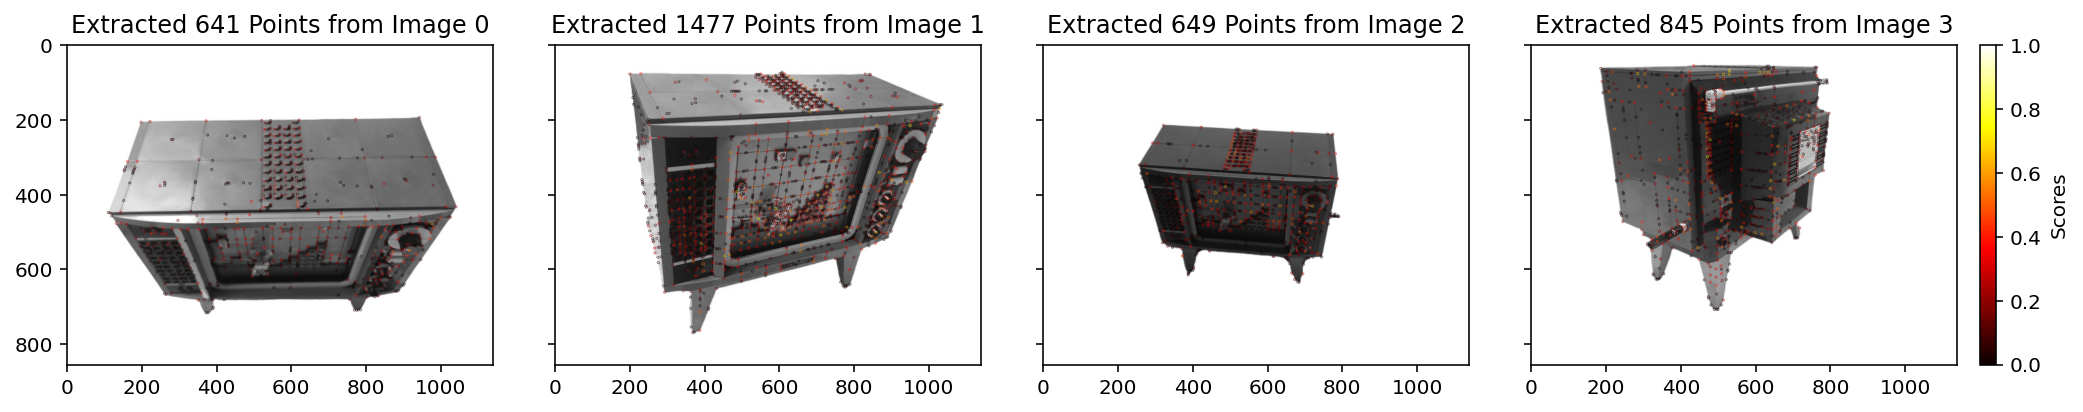

In [147]:
def display_feature_points(images, keypoints, scores):
    fig, ax = plt.subplots(1, len(images), figsize=(16.5, 2.8), constrained_layout=True, sharey=True)
    fig.set_dpi(plot_dpi)
    fig.tight_layout()
    fig.colorbar(cm.ScalarMappable(cmap=cm.hot), ax=fig.get_axes(), orientation='vertical', label='Scores', pad=0.01)

    for i in range(0, len(images)):
        out_img = images[i].copy()
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2RGB)
        kpts = np.round(keypoints[i]).astype('int')
        
        for (x, y), s in zip(kpts, scores[i]):
            color = (np.array(cm.hot(s)) * 255).astype('uint8')
            cv2.circle(out_img, (x, y), 3, color.tolist(), 1, lineType=cv2.LINE_AA)

        ax[i].set_title('Extracted {} Points from Image {}'.format(len(kpts), i))
        ax[i].imshow(out_img)

display_feature_points(gray_images, keypoints, scores)

### Matching Feature Point using SuperGlue

In [148]:
from thirdparty.SuperGluePretrainedNetwork.models.superglue import SuperGlue

superglue_conf =  {
    'output': 'matches-spg',
    'conf': {
        'descriptor_dim': 256,
        'weights': 'indoor',
        'match_threshold': 0.7
    }
}

sg_model = SuperGlue(superglue_conf)
sg_model.eval()

Loaded SuperGlue model ("indoor" weights)


SuperGlue(
  (kenc): KeypointEncoder(
    (encoder): Sequential(
      (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
      (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
    )
  )
  (gnn): AttentionalGNN(
    (layers): ModuleList(
      (0): AttentionalPropagation(
        (attn): MultiHeadedAttention(
          (merge): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
    

In [149]:
pretrained_sg_model = torch.load(
    'thirdparty/SuperGluePretrainedNetwork/models/weights/superglue_{}.pth'.format(superglue_conf['conf']['weights']),
    map_location=device
)
sg_model.load_state_dict(pretrained_sg_model, strict=True)

<All keys matched successfully>

In [150]:
gray_images[0].shape

(855, 1140)

In [157]:
def generate_sg_data(index_pairs, gray_images, sp_predicts):
    i, j = index_pairs
    feats0, feats1 = sp_predicts[i], sp_predicts[j]
    img_size0, img_size1 = gray_images[i].shape, gray_images[j].shape
    data = {}

    for k in feats0.keys():
        data[k + '0'] = feats0[k][0]
    for k in feats1.keys():
        data[k + '1'] = feats1[k][0]

    data['image0'] = torch.empty((1, 1, ) + tuple(img_size0)[:-1]).to(device)
    data['image1'] = torch.empty((1, 1, ) + tuple(img_size1)[:-1]).to(device)
    data = {k: v[None].float() for k, v in data.items()}

    return data
    
sg_datas = [generate_sg_data(p, gray_images, sp_predicts) for p in gray_image_index_pairs]

In [162]:
sg_predicts = []
sg_time_ms = []

for inp in sg_datas:
    b = datetime.datetime.now()
    pred = sg_model(inp)
    e = datetime.datetime.now()

    sg_time_ms.append((e - b).microseconds / 1000)
    sg_predicts.append(pred)
    
sg_time_ms


[923.596,
 361.329,
 463.02,
 732.232,
 739.605,
 365.942,
 90.069,
 168.371,
 609.849,
 910.43,
 349.41,
 560.991]

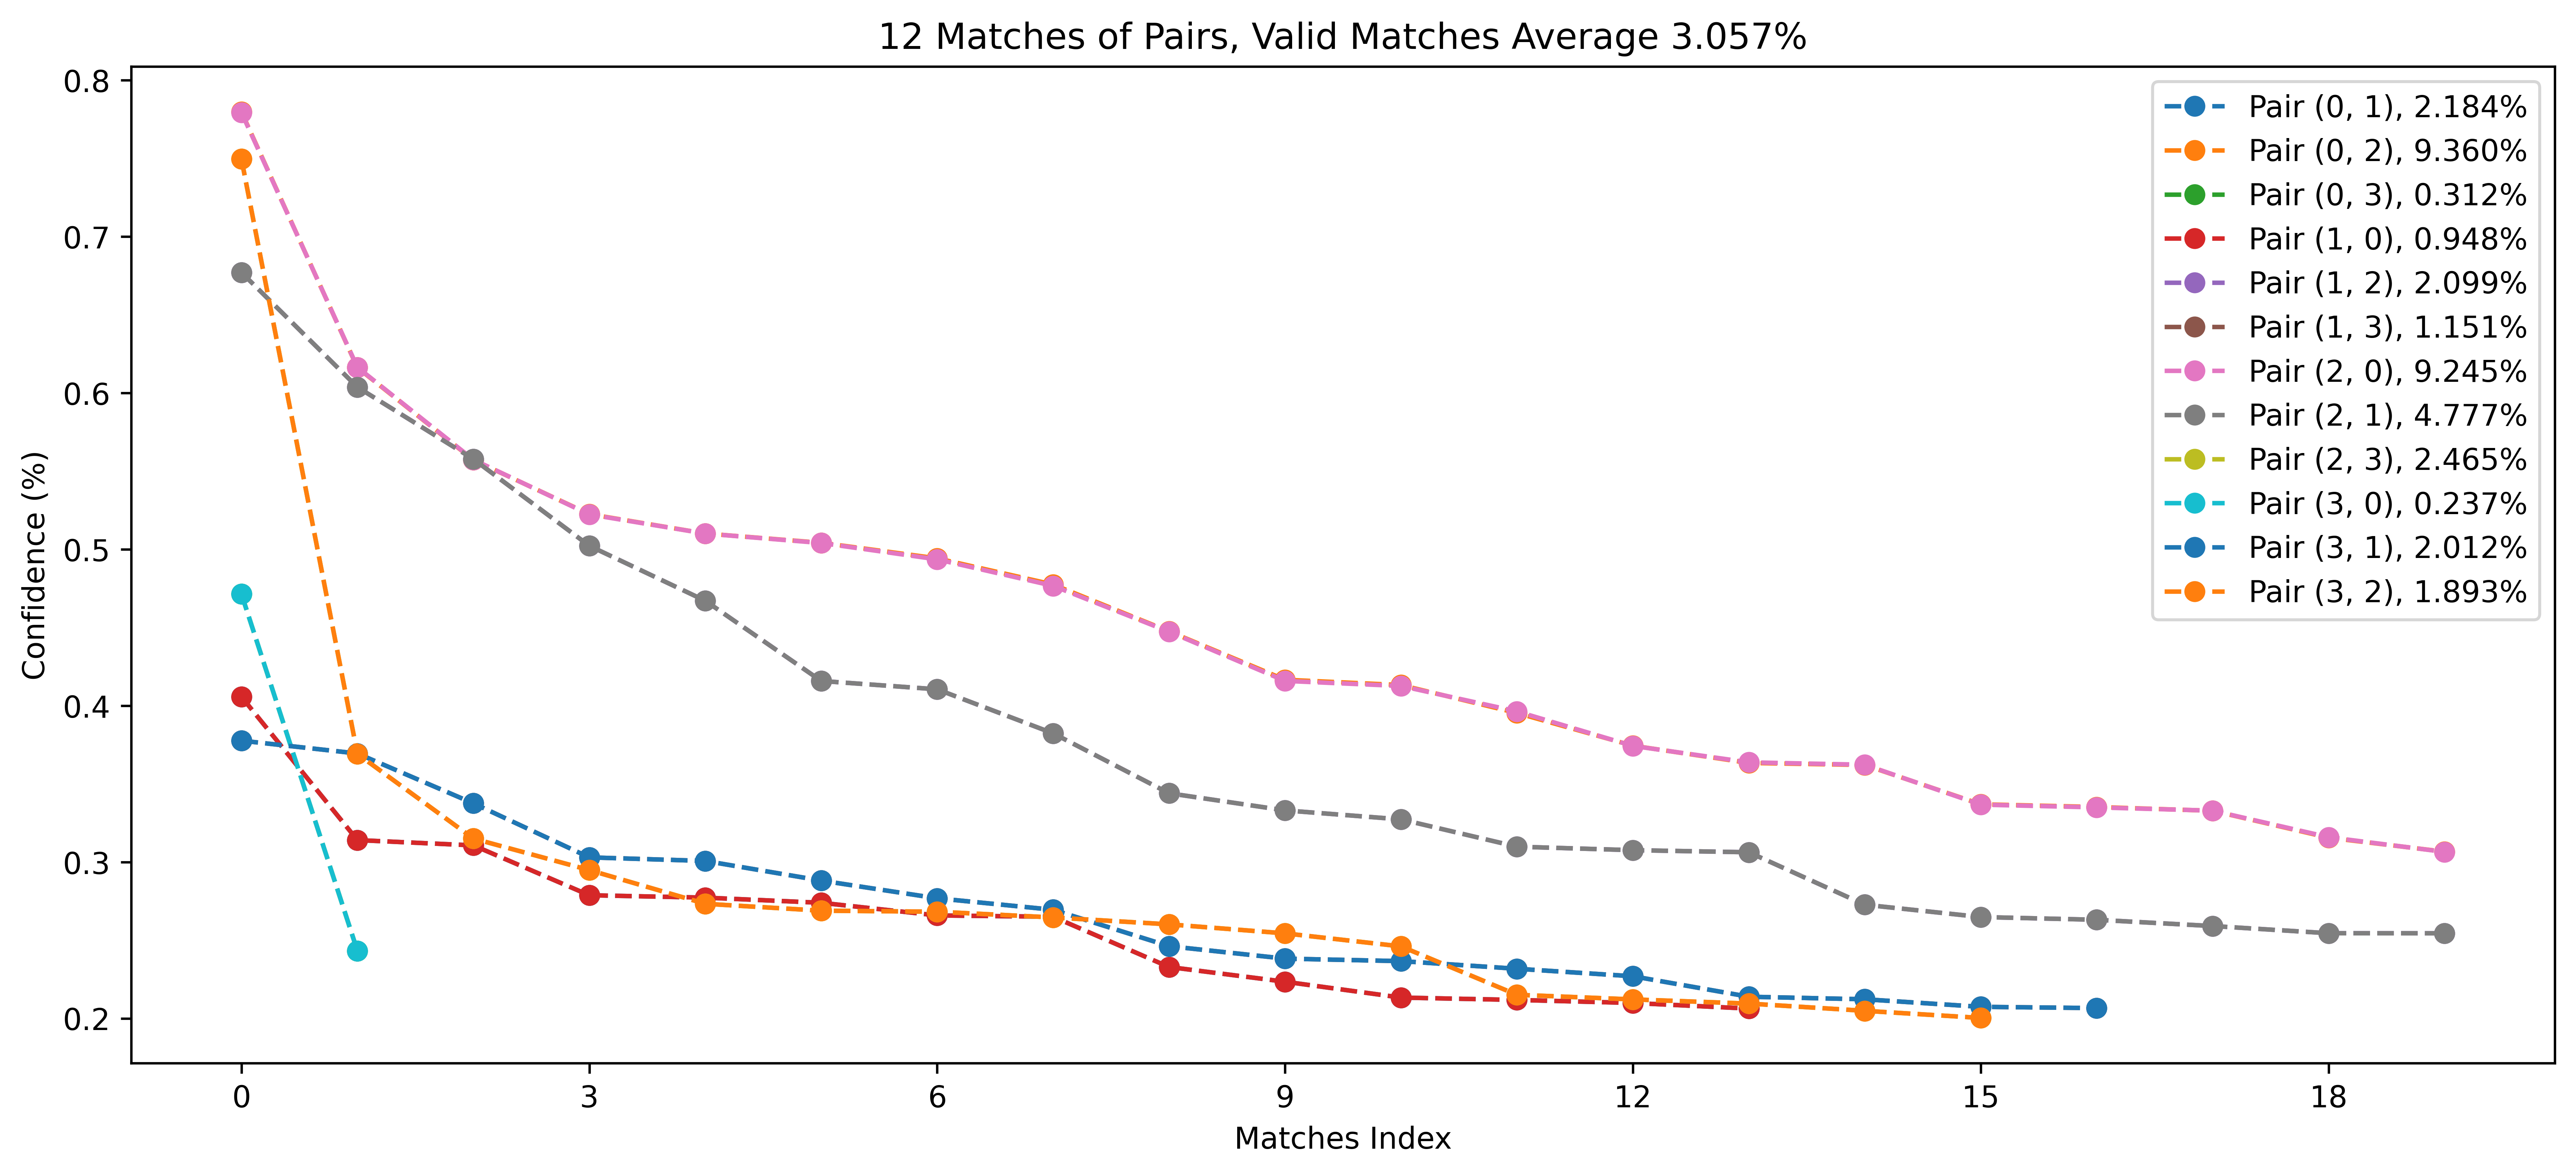

In [169]:
def display_matches_scores(index_pairs, sg_predicts, n=20):
    percentages = []

    plt.figure(figsize=(14.5, 6), dpi=600)
    plt.xticks(range(0, n, 3))
    plt.xlabel('Matches Index')
    plt.ylabel('Confidence (%)')

    for ((i, j), pred) in zip(index_pairs, sg_predicts):
        matches = pred['matches0'][0].detach().numpy()
        valid = matches > -1
        valid_scores = pred['matching_scores0'][0].detach().numpy()[valid]
        valid_scores_sorted = sorted(valid_scores, reverse=True)
        percentage = len(valid_scores_sorted) / len(matches)

        percentages.append(percentage)

        x = np.arange(0, len(valid_scores_sorted))
        y = valid_scores_sorted

        plt.plot(x[:n], y[:n], linestyle='--', marker='o', label='Pair {}, {:.3f}%'.format((i, j), percentage * 100))
        plt.legend()

    plt.title('{} Matches of Pairs, Valid Matches Average {:.3f}%'.format(len(sg_predicts), np.average(percentages) * 100))

display_matches_scores(gray_image_index_pairs, sg_predicts)

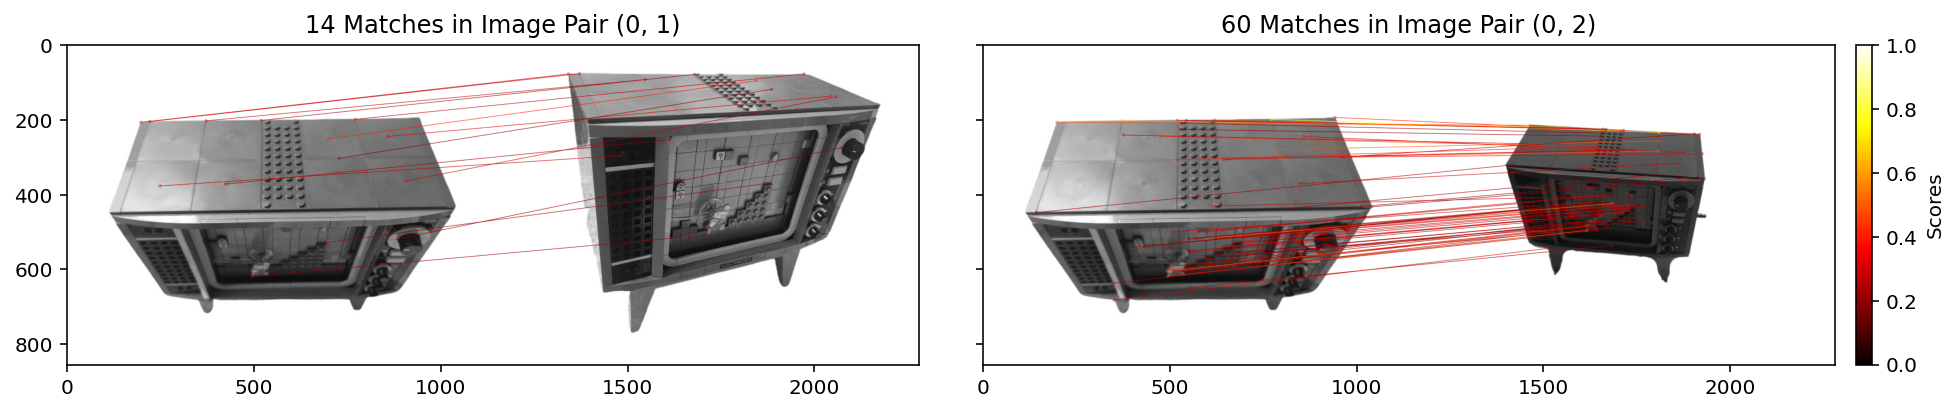

In [186]:
def display_matches(index_pairs, gray_images, sp_predicts, sg_predicts, n=2):
    fig, ax = plt.subplots(1, n, figsize=(15.5, 2.8), constrained_layout=True, sharey=True)
    fig.set_dpi(plot_dpi)
    fig.tight_layout()
    fig.colorbar(cm.ScalarMappable(cmap=cm.hot), ax=fig.get_axes(), orientation='vertical', label='Scores', pad=0.01)

    for ((i, j), sg_pred, k) in zip(index_pairs[:n], sg_predicts[:n], range(0, n)):
        matches = sg_pred['matches0'][0].detach().numpy()
        valid = matches > -1

        feats0, feats1 = sp_predicts[i], sp_predicts[j]
        kpts0, kpts1 = feats0['keypoints'][0].__array__(), feats1['keypoints'][0].__array__()
        mkpts0, mkpts1 = np.round(kpts0[valid]).astype('int'), np.round(kpts1[matches[valid]]).astype('int')

        valid_scores = sg_pred['matching_scores0'][0].detach().numpy()[valid]
        percentage = len(valid_scores) / len(matches)

        (h0, w0), (h1, w1) = gray_images[i].shape, gray_images[j].shape
        stitch_image = np.empty((max(h0, h1), w0 + w1), dtype=np.uint8)
        stitch_image[:h0, :w0] = gray_images[i]
        stitch_image[:h1, w0:] = gray_images[j]
        stitch_image = cv2.cvtColor(stitch_image, cv2.COLOR_GRAY2RGB)

        for (x0, y0), (x1, y1), s in zip(mkpts0, mkpts1, valid_scores):
            color = (np.array(cm.hot(s)) * 255).astype('uint8')

            cv2.line(stitch_image, (x0, y0), (x1 + w0, y1), color.tolist(), thickness=1, lineType=cv2.LINE_AA)
            cv2.circle(stitch_image, (x0, y0), 3, color.tolist(), 1, lineType=cv2.LINE_AA)
            cv2.circle(stitch_image, (x1 + w0, y1), 3, color.tolist(), 1, lineType=cv2.LINE_AA)
        
        ax[k].set_title('{} Matches in Image Pair {}'.format(len(valid_scores), (i, j)))
        ax[k].imshow(stitch_image)

display_matches(gray_image_index_pairs, gray_images, sp_predicts, sg_predicts)